## 필요한 라이브러리 불러오기

In [1]:
import os
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
#gpu 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터셋 준비하기

In [3]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    data_dir = os.getenv('HOME') + '/aiffel/stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## cam모델 생성 및 학습

### 모델 만들기

In [5]:
#ResNet50 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     #Imagenet 분류기 fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    #ResNet50의 매개변수 pooling에 'avg'를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있음
    pooling='avg',      #GAP 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [6]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## 모델 학습시키기

In [7]:
#bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img과정에서 제외함.
def normalize_and_resize_img(input):
    #Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
#데이터셋에 전처리와 배치처리를 적용. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

#구성된 배치의 모양을 확인. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [9]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [10]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 159s 199ms/step - loss: 2.2044 - accuracy: 0.4487 - val_loss: 3.2445 - val_accuracy: 0.2279
Epoch 2/15
750/750 [==============================] - 153s 204ms/step - loss: 0.7226 - accuracy: 0.8036 - val_loss: 1.1152 - val_accuracy: 0.6715
Epoch 3/15
750/750 [==============================] - 155s 207ms/step - loss: 0.2378 - accuracy: 0.9502 - val_loss: 0.9475 - val_accuracy: 0.7214
Epoch 4/15
750/750 [==============================] - 156s 208ms/step - loss: 0.0707 - accuracy: 0.9923 - val_loss: 0.8996 - val_accuracy: 0.7391
Epoch 5/15
750/750 [==============================] - 156s 208ms/step - loss: 0.0291 - accuracy: 0.9982 - val_loss: 0.9129 - val_accuracy: 0.7419
Epoch 6/15
750/750 [==============================] - 156s 208ms/step - loss: 0.0179 - accuracy: 0.9993 - val_loss: 0.9277 - val_accuracy: 0.7353
Epoch 7/15
750/750 [==============================] - 156s 208ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.9284 -

In [11]:
#학습시킨 가중치 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map1/cam_model.h5'
cam_model.save(cam_model_path)
print("Save completed")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Save completed


### 학습된 모델에서 cam 생성

### CAM

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


116


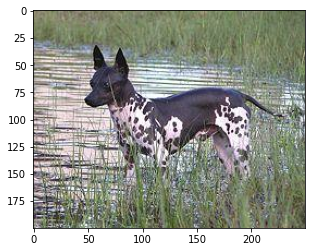

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [16]:
#이전에 학습한 모델 로드
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map1/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [17]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    #학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의.
    #model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        #W * f 를 통해 class별 activation map을 계산.
        cam_image += w * conv_outputs[:, :, i]
    
    #activation score를 normalize.
    cam_image /= np.max(cam_image) 
    cam_image = cam_image.numpy()
    #원래 이미지의 크기로 resize.
    cam_image = cv2.resize(cam_image, (width, height)) 
    
    return cam_image

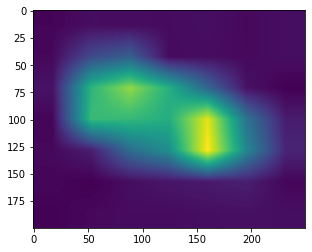

In [18]:
#CAM 이미지 생성
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [19]:
#그려진 CAM과 원본 이미지 합침
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

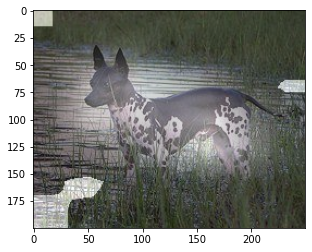

In [20]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## Grad-CAM

In [21]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    #특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의.
    #해당 레이어의 이름으로 찾은 후 output으로 추가.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    #Gradient를 얻기 위해 tape를 사용.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] #원하는 class(여기서는 정답으로 활용) 예측값을 얻음.
        output = conv_output[0] #원하는 layer의 output을 얻음.
        grad_val = tape.gradient(loss, conv_output)[0] #예측값에 따른 Layer의 gradient를 얻음.

    weights = np.mean(grad_val, axis=(0, 1)) #gradient의 GAP으로 class별 weight를 구함.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        #각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻음.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

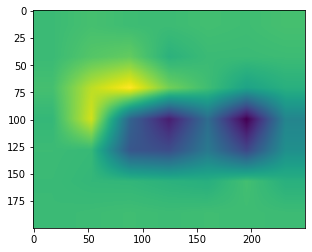

In [22]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

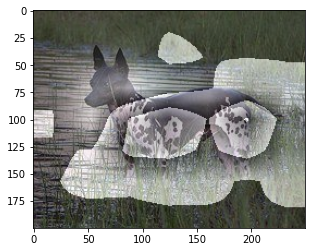

In [23]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

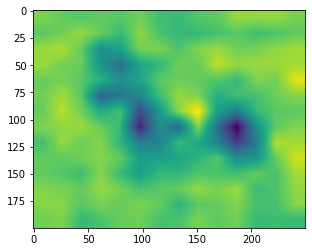

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

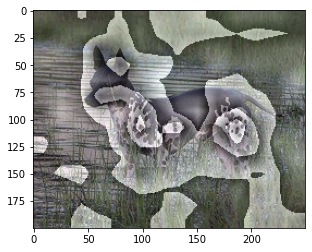

In [25]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

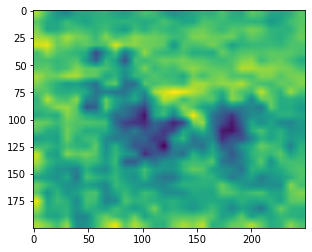

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

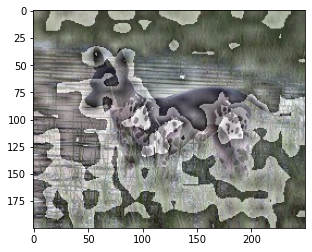

In [27]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

### Detection with CAM

100


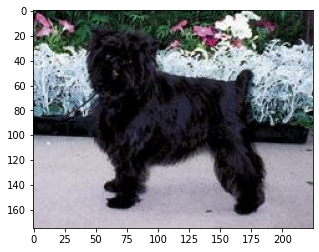

In [28]:
#새로운 이미지
item = get_one(ds_test)
print(item['label'])

plt.imshow(item['image'])
plt.show()

### CAM

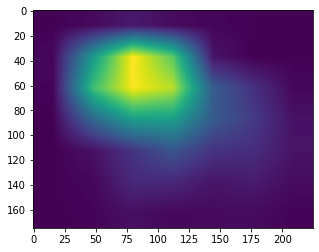

In [29]:
#CAM 이미지
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [30]:
#바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앰.
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    #OpenCV의 findContours()와 minAreaRect()로 사각형을 찾음.
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    
    #rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있음.
    rect = cv2.boxPoints(rotated_rect)   #boxPoints()로 이를 꼭지점으로 바꾸어 줌.
    rect = np.int0(rect)
    
    return rect

In [31]:
ige = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 12,   4],
       [198, -11],
       [212, 145],
       [ 26, 161]])

In [32]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)
plt.show()

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'drawContours'
> Overload resolution failed:
>  - image is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'image'


### Grad-CAM

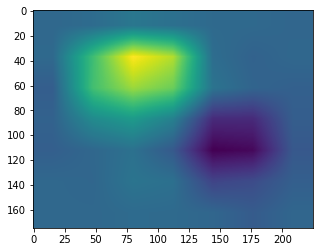

In [33]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [34]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[  8,  12],
       [132, -16],
       [165, 128],
       [ 41, 156]])

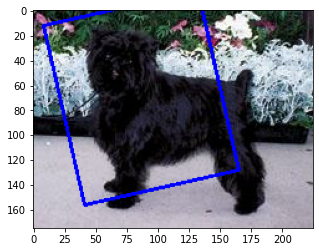

In [35]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)

### IoU(Intersection over Union)

In [36]:
#rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어짐. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    
    return bbox

In [46]:
#ground truth bbox
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [47]:
#CAM bbox
#위에서 구했던 rect를 minmax bbox 형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.06285714285714286, 0.05333333333333334, 0.92, 0.9422222222222222]

In [48]:
#Grad-CAM bbox
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[-0.09142857142857143,
 0.035555555555555556,
 0.8914285714285715,
 0.7333333333333333]

In [49]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [50]:
#CAM bbox와 정답 bbox의 IoU
get_iou(pred_bbox, item ['objects']['bbox'][0])

0.6354948280677571

In [51]:
#Grad-CAM bbox와 정답 bbox의 IoU
get_iou(grad_pred_bbox, item ['objects']['bbox'][0])

0.569209558049056

## 회고 

##### Class activation map을 비교하면 CAM 방식은 전반적인 면적인 반면에 Grad-CAM 방식은 특정 부분에만 집중되어 있는 것을 볼 수 있다.

##### 바운딩 박스의 결과는 Grad-CAM 방식이 detection을 제대로 한 결과를 보인 반면, CAM 방식은 바운딩 박스가 제대로 된 결과라고 보기 힘든 겹쳐진 모양으로 나왔다. 겹쳐서 나온 이유는 잘 모르겠으나 detection이 제대로 되었다고 하긴 힘들 것 같다.

##### IoU를 보면 Grad-CAM 방식이 좀 더 높은 점수를 얻었다. 아무래도 CAM 방식보다 Grad-CAM의 바운딩박스가 detection을 잘 했기 때문인 것 같다.

##### 이번 노드역시 너무나 어려웠지만 다행히? 노드를 그냥 따라하기만 하면 되는 노드여서 어찌저찌 한것 같다. 하지만 그대로 따라하면서도 회고를 쓰려면 공부를 해야하기에 노드를 함께 보면서 코드를 진행해서 어느정도는 공부가 된거같다. 저에게는 이런 노드가 훨씬 머리에 많이 남는 노드인것 같다.